# Belief Propagation from Geo-Located Imagery

In [2]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [223]:
## Define variables
# Label imports
groundTruth = "./data/beirutDamages.shp" # Damages shapefile
crs = 'EPSG:4326' # Coordinate system to be used
cn = 'decision' # Column for classes
splitString = False # Only use first word in class column
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Data imports
dataTypes = ['hr','ifg']
pre, post = 'PreFile', 'PostFile'
hrPreFile = "data/highRes/20JUL31_HR_LatLon.tif" # High Res image Pre
hrPostFile = "data/highRes/20AUG05_HR_LatLon.tif" # High resolution img Post
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
max_nodes = 20000 # Maximum number of nodes used

# Map filtering of location
lat, lon, zoom = 33.893, 35.512, 14 # Map properties
stdTest = False # Use standard area for Beirut testing

# Class options
nClasses = False # Enforce number of classes (False -> # classes in labels)
classNames = False #['Undamaged','Damaged'] # Enforce names of classes (False -> cl0, cl1,...)
classAssign = False #[['GREEN','LAND'],['YELLOW','RED','TOTAL']] # Enforce class grouping (False -> Clustering is performed)
pca, pcaComps, meanCluster = False, 2, True # Clustering properties if used

# Edge creation
adjacent, geoNeighbours = False, 4 # geographical edges, n neighbours
neighbours = [3,3] # n neighbours for each data type

In [84]:
## Import Labels and combine
labels = ip.shape_to_gdf(groundTruth, splitString, cn, crs=crs)

# Display map of assessments upon which to draw Polygon for analysis
m1 = pl.create_map(lat, lon, zoom)
m1 = pl.plot_assessments(labels, m1)
m1, testPoly = pl.draw_polygon(labels, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [5]:
# Reproject data to used crs
for i in dataTypes:
    if crs not in ip.get_crs(globals()[i+post]):
        globals()[i+post] = ip.conv_coords([globals()[i+post]], ["data/"+i+"PostConv.tif"], crs)[0]
        if i+pre in locals(): globals()[i+pre] = ip.conv_coords([globals()[i+pre]], ["data/"+i+"PreConv.tif"], crs)[0]        

In [143]:
# Data Imports
# Import first data type
df, crop = ip.img_to_df(globals()[dataTypes[0]+post], testPoly, crs=crs)
if dataTypes[0]+pre in locals():
    preDf, _ = ip.img_to_df(globals()[dataTypes[0]+pre], testPoly, crs=crs)
    df -= preDf

# Import other data types
if len(dataTypes) > 1:
    crop.rio.to_raster("croptemp.tif")
    for tp in dataTypes[1:]:
        ip.resample_tif(globals()[tp+post], testPoly, tp+'Posttemp.tif')
        globals()[tp+'Array'] = ip.tif_to_array(tp+'Posttemp.tif', 'resample')
        if tp+pre in locals(): 
            ip.resample_tif(globals()[tp+pre], testPoly, tp+'Pretemp.tif')
            globals()[tp+'Array'] -= ip.tif_to_array(tp+'Pretemp.tif', 'resample')
    ip.del_file_endings(".", "temp.tif")

# Concatenate data types
typesUsed = [list(df.columns.values), dataTypes[1:]]
data = df.copy()
for tp in dataTypes[1:]: data[tp]=globals()[tp+'Array'].flatten()
data.dropna(inplace=True)

# Sample data and create geodataframe
gdf = ip.get_sample_gdf(data, max_nodes, crs)

data/highRes/20AUG05_HR_LatLon.tif read completed.
data/highRes/20JUL31_HR_LatLon.tif read completed.


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2940: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return runner(coro)


./data/beirutPrePostExplosionIfg.tif read completed.
./data/beirutPrePreExplosionIfg.tif read completed.


In [163]:
## Assign Label classes to data
defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.to_crs(crs).copy(), gdf.copy() # Default classes from labels
usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

if not nClasses: 
    nClasses = defClasses # If default classes used
    classesUsed = usedNames.copy()
elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
elif nClasses < defClasses: # Perform class grouping
    if not classAssign: # Perform clustering
        # Assign labels to each pixel
        allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(hf.get_polygon(testPoly, conv=True))])
        # Run PCA if set to True
        X = hf.run_PCA(dataUsed[typesUsed[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[typesUsed[0]]
        # Run clustering
        kmeans, clusterClasses, initLabels = hf.run_cluster(X.iloc[allPixels[cn].dropna().index].values.reshape(-1,len(typesUsed[0])), allPixels[cn].dropna(), meanCluster, nClasses)
        print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
        # Create groups of classes
        classesUsed = []
        for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
    else: 
        classesUsed = classAssign
        #used = [i in flatten_list(classesUsed) for i in labelsUsed[cn]]
        initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs)
        
    # Assign labels for each pixel after clustering
    labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)

In [224]:
# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, hf.get_polygon(testPoly, conv=True))

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], classNames=classNames, column = cn)

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=typesUsed, neighbours=neighbours)

In [225]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 20000, Edges: 60000
It	Loss	Label change

0	5.80470e-01		7820

1	2.19222e-01		1207

2	9.49152e-02		333

3	4.02294e-02		83

4	1.71041e-02		22

5	7.22847e-03		22

6	3.18243e-03		23

7	1.42510e-03		3

8	6.34394e-04		3

Time elapsed: 16.057302713394165 seconds


False
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1902
           1       0.48      0.45      0.46      1143

    accuracy                           0.61      3045
   macro avg       0.58      0.58      0.58      3045
weighted avg       0.60      0.61      0.61      3045



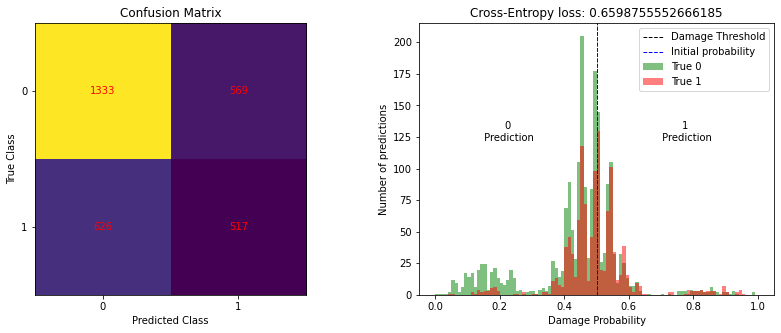

In [226]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=classNames)

fig, axs = pl.create_subplots(1,2, figsize=[14,5])

# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes if len(labels[cn].unique()) == nClasses else list(range(nClasses)))
  
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)

pl.show_plot()

In [227]:
# Save figure
pl.save_plot(fig, 'results/Beirut_UN_nd{}_cls{}{}_neighbours{}{}_std{}_adj{}{}'.format(str(len(nodes)),str(nClasses),str(classesUsed),
                                                                                      str(dataTypes),str(neighbours),str(stdTest),
                                                                                      str(adjacent),str(geoNeighbours)))

In [ ]:
# Visualise spatial results
fig, axs = pl.create_subplots(2,2,figsize=[15,12])

prePlot = pl.belief_plot(nodes, axs[0,0], 'RED', normalise=False)
postPlot = pl.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (pl.cropped_ifg(ifgPreFile,testPoly)-pl.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

pl.show_plot()